<center>
<img src="../../img/ml_theme.png">
# Майнор "Интеллектуальный анализ данных" 
# Курс "Современные методы машинного обучения"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: Евгений Рябенко (Senior Data Scientist, Vympelcom, Netherlands)
</center>
Материал распространяется на условиях лицензии <a href="http://www.microsoft.com/en-us/openness/default.aspx#Ms-RL">Ms-RL</a>. Можно использовать в любых целях, но с обязательным упоминанием автора.

# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [6]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/alex/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


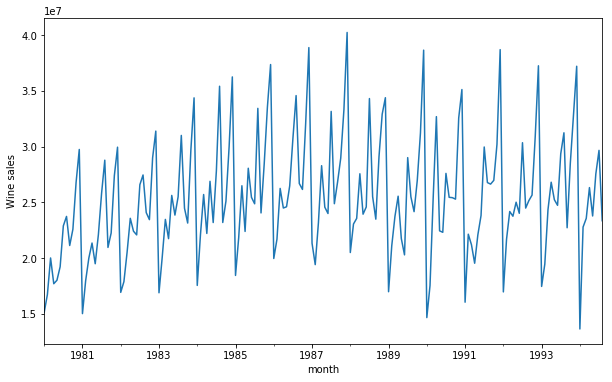

In [7]:
wine = pd.read_csv('monthly-australian-wine-sales.csv',
                   index_col=['month'], parse_dates=['month'], dayfirst=True)
wine.sales = wine.sales * 1000
figsize(10,6)
wine.sales.plot()
plt.ylabel('Wine sales')
pylab.show()

In [13]:
wine.tail()

,sales,sales_box,sales_box_diff,sales_box_diff2
month,,,,
1994-04-01,26323000,236.797130,-1.037310,0.795331
1994-05-01,23779000,231.068341,-3.335119,-2.297809
1994-06-01,27549000,239.407994,6.134354,9.469474
1994-07-01,29660000,243.702771,0.603791,-5.530563
1994-08-01,23356000,230.070918,-16.684633,-17.288424


In [14]:
wine.shape

(176, 4)

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.051161


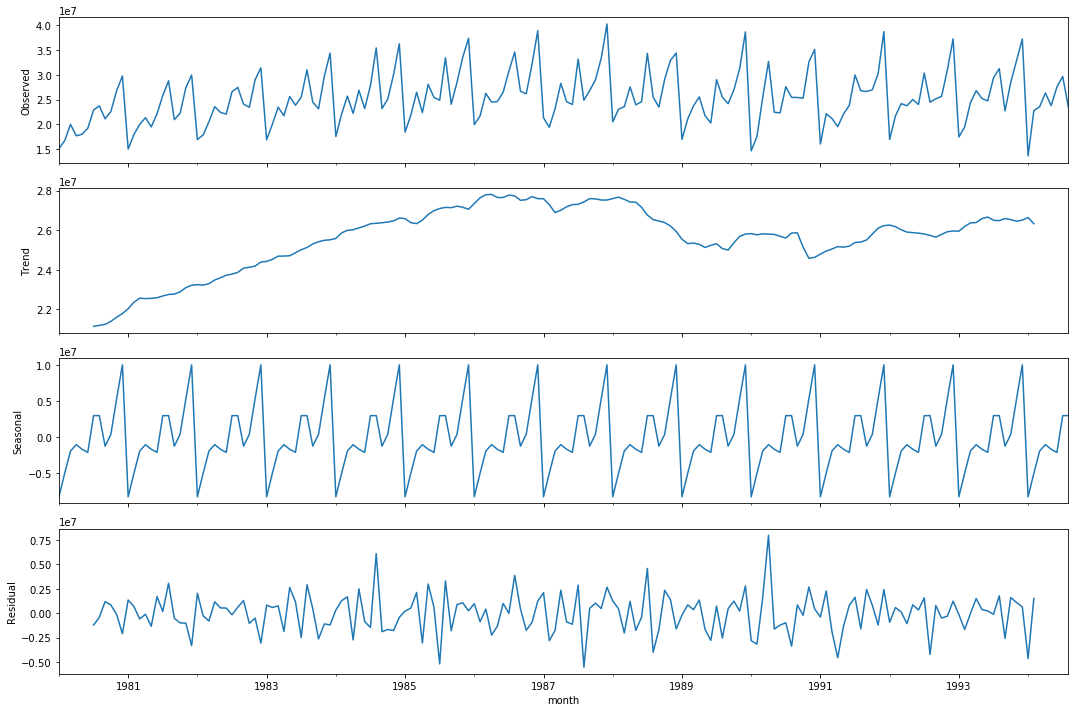

In [8]:
figsize(15,10)
sm.tsa.seasonal_decompose(wine.sales).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


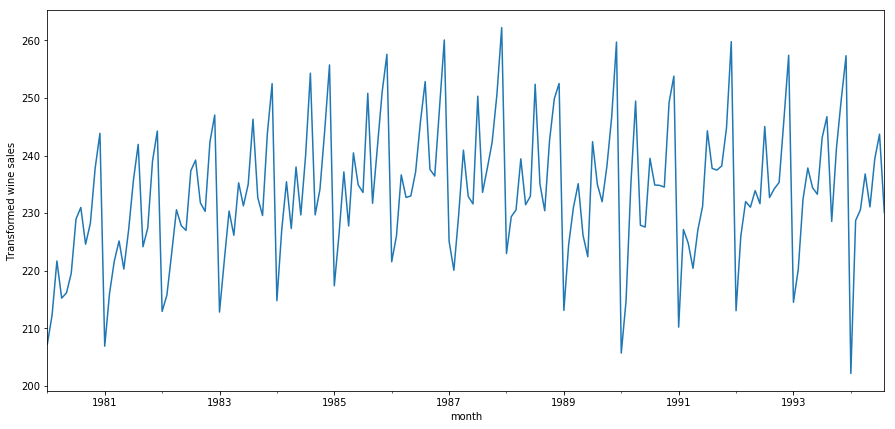

In [9]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
figsize(15,7)
wine.sales_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.128317


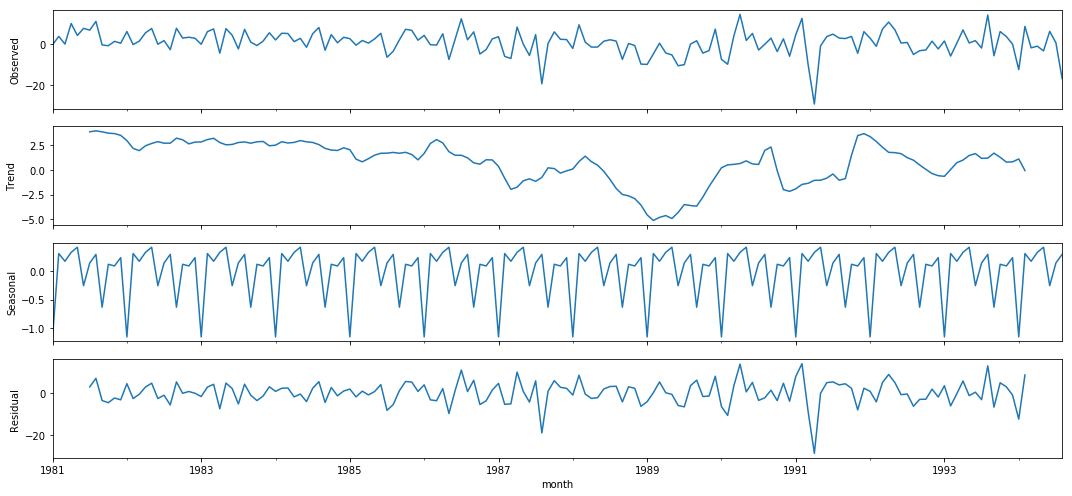

In [10]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


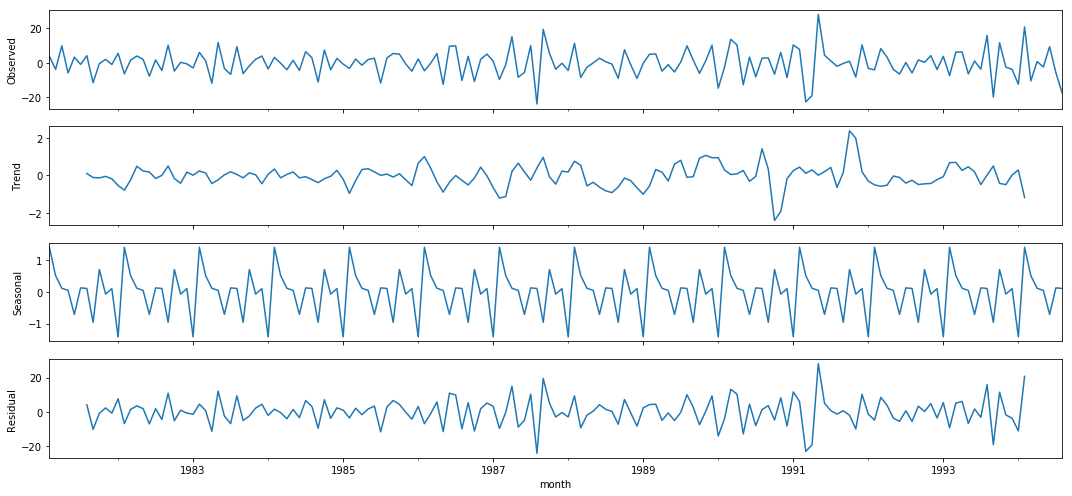

In [11]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

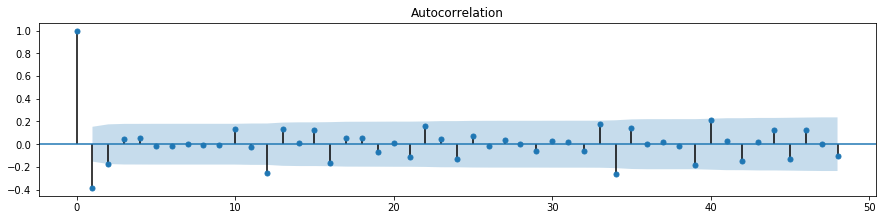

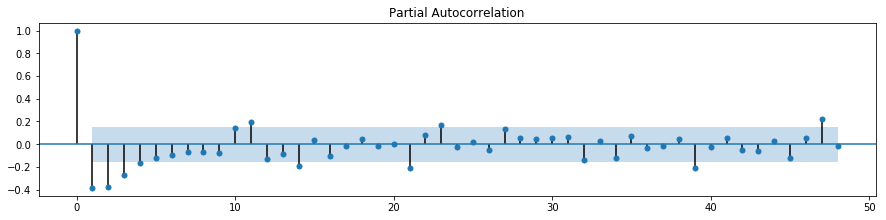

In [12]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [10]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
CPU times: user 32.4 s, sys: 429 ms, total: 32.9 s
Wall time: 20 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
23  (2, 1, 0, 1)  1007.801553
25  (2, 1, 1, 1)  1008.786538
27  (2, 2, 0, 1)  1009.284267
35  (3, 1, 0, 1)  1009.723537
6   (0, 1, 1, 1)  1010.126754


Лучшая модель:

In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -498.901
Date:                            Thu, 08 Dec 2016   AIC                           1007.802
Time:                                    09:58:49   BIC                           1023.654
Sample:                                01-01-1980   HQIC                          1014.231
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111   

Её остатки:

Критерий Стьюдента: p=0.257990
Критерий Дики-Фуллера: p=0.000000


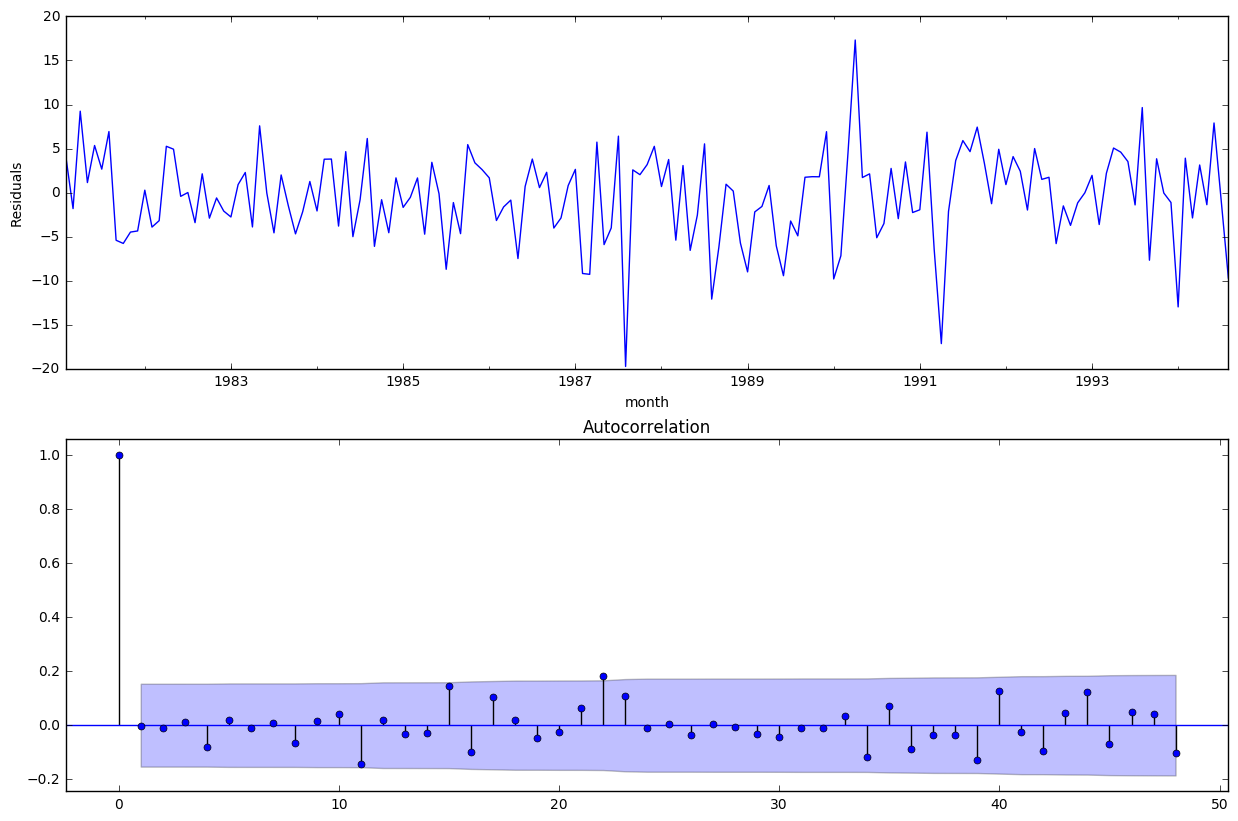

In [15]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

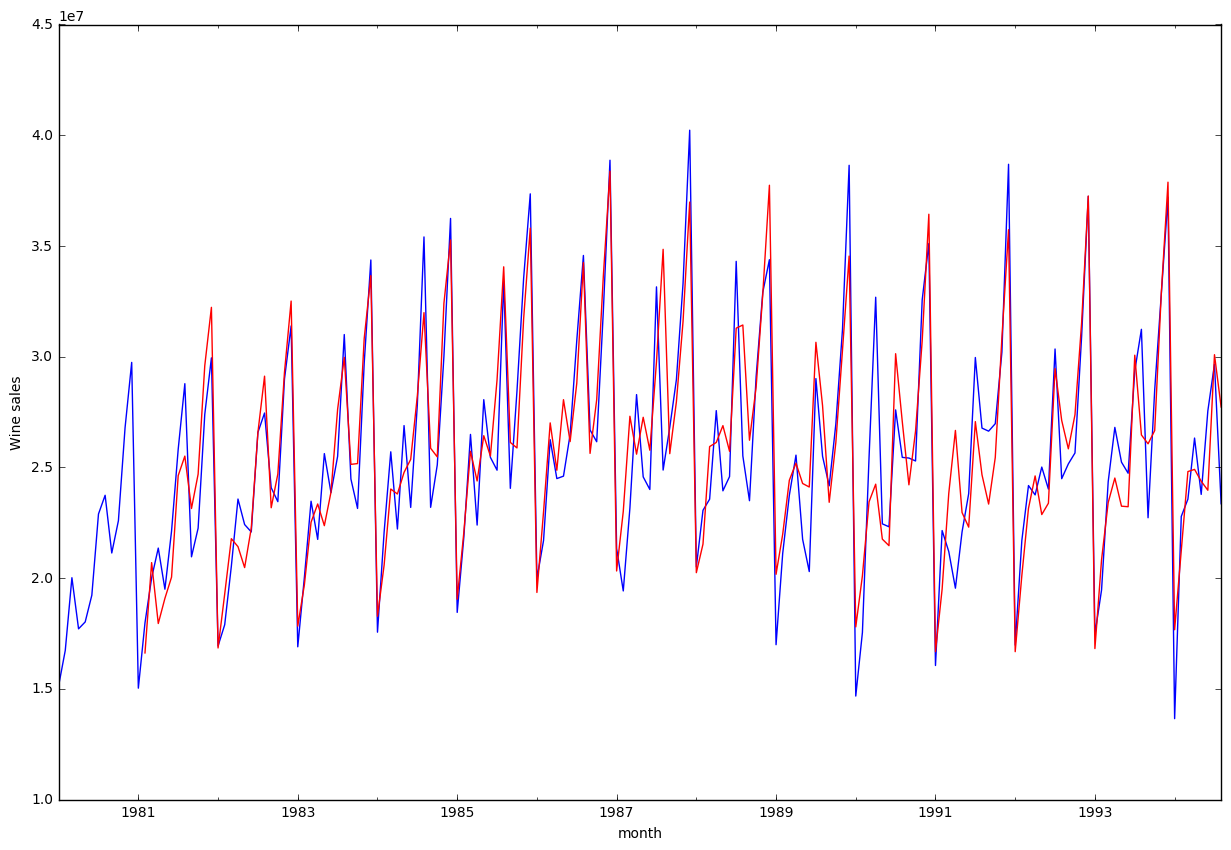

In [16]:
wine['model'] = invboxcox(best_model.fittedvalues, lmbda)
wine.sales.plot()
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

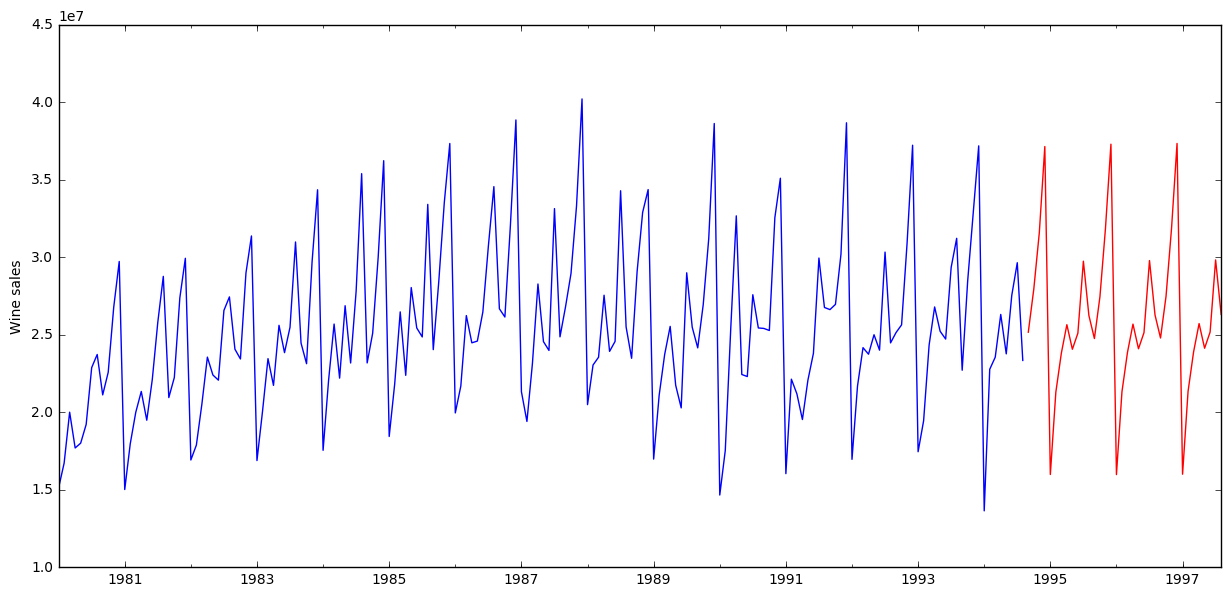

In [17]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

# Предсказание количество несчастных случаев в США

In [8]:
# возьмите файл accidental-deaths-in-usa-monthly.csv и постройте прогноз на пару лет вперёд